## Sparse Autoencoders (experiments on MNIST)

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [81]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),  # нормализация к диапазону [-1, 1]
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [82]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## The simplest 1-layer encoder/decoder

In [83]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x

In [84]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._l1_reg = None
        self._loss = None
        self.hidden = None  # hidden vector
        self.optim = optim.Adam(self.parameters(), lr=lr)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.hidden = h  # save the hidden vector
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def l1_regularizer(self, size_average=True):
        """
        L1 regularizer
        """
        batch_l1_reg = torch.abs(self.hidden).sum(0)
        if size_average:
            self._l1_reg = batch_l1_reg.mean()
        else:
            self._l1_reg = batch_l1_reg.sum()
        return self._l1_reg
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs) 
        return self._loss

In [85]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        for i, model in enumerate(models.values()):
            model.optim.zero_grad()
            output = model(data)
            l1_reg_term = model.l1_regularizer()
            loss = model.loss(output, data) + alpha[i] * l1_reg_term  # * l1-regularization coefficient (alpha), for batch
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._l1_reg))
        print(line + losses)

In [86]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
l1_lambda = lambda p: 'l1 reg: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + l1_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    l1_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():                
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                l1_loss[k] += m.l1_regularizer(size_average=False).item()
    
    for i, k in enumerate(models):
        test_loss[k] /= (test_size * 784)
        l1_loss[k] *= alpha[i] * (test_size // 50)    # correct by a number of batches in the test_dataset
        l1_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], l1_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], l1_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [87]:
def plot_results(model='64'):
    print("\t=================\n\t{} hidden neurons\n\t=================".format(model))
    data, _ = next(iter(test_loader))
    data = data.to(device)

    # 1. Create and view reconstructed images
    output = models[model](data)
    to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()

    # 2. Create and decode from sparse encoded representation
    h_vector = torch.eye(int(model))
    print(h_vector.max(), h_vector.min())
    decoded = models[model].decode(h_vector.to(device))
    dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()

    with torch.no_grad():
        encoded = models[model].E(data.view(-1, 28*28).to(device))
        print((torch.abs(encoded) > 0.5).sum(1))
        
        # 3. Fill zeros for values above the threshold
        encoded[torch.abs(encoded) < 0.5] = 0.
        decoded_f = models[model].decode(encoded)
        f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
        
    print("Reference:")
    plot_mnist(data.data.cpu().numpy(), (5, 10))
    print("Reconstructed:")
    plot_mnist(to_plot, (5, 10))
    print("Reconstructed zero-filled:")
    plot_mnist(f_to_plot, (5, 10))
    print("Decode from a sparse vector:")
    plot_mnist(dec_to_plot, (8, 8))

In [112]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
alpha = [3e-3, 3e-3, 3e-3]     # regularization coefficient

train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

[model.to(device) for model in models.values()];

In [113]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 1.035709 32: 0.999126 64: 0.975734
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.743758 32: 0.471743 64: 0.314438
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.468894 32: 0.318516 64: 0.270062
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.364899 32: 0.291669 64: 0.242793
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.308714 32: 0.261121 64: 0.208041
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.284431 32: 0.242010 64: 0.184891
Test set:
16: loss: 0.3009	l1 reg: 0.4739
32: loss: 0.2562	l1 reg: 0.3741
64: loss: 0.1935	l1 reg: 0.3394

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.290012 32: 0.247434 64: 0.187784
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.278847 32: 0.228352 64: 0.165986
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.286315 32: 0.231666 64: 0.165288
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.270037 32: 0.215862 64: 0.152540
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.261142 32: 0.206982 64: 0.144643
Train Epoch

Train Epoch: 15 [10000/50000 (20%)]	Losses 16: 0.130161 32: 0.073228 64: 0.035784
Train Epoch: 15 [20000/50000 (40%)]	Losses 16: 0.108415 32: 0.062957 64: 0.030412
Train Epoch: 15 [30000/50000 (60%)]	Losses 16: 0.104860 32: 0.057668 64: 0.028029
Train Epoch: 15 [40000/50000 (80%)]	Losses 16: 0.116566 32: 0.063879 64: 0.031869
Train Epoch: 15 [50000/50000 (100%)]	Losses 16: 0.111895 32: 0.063017 64: 0.029861
Test set:
16: loss: 0.1134	l1 reg: 0.1798
32: loss: 0.0643	l1 reg: 0.1737
64: loss: 0.0308	l1 reg: 0.1519

Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.117675 32: 0.066475 64: 0.031774
Train Epoch: 16 [10000/50000 (20%)]	Losses 16: 0.107460 32: 0.060301 64: 0.029201
Train Epoch: 16 [20000/50000 (40%)]	Losses 16: 0.108948 32: 0.060456 64: 0.029348
Train Epoch: 16 [30000/50000 (60%)]	Losses 16: 0.105595 32: 0.059145 64: 0.028543
Train Epoch: 16 [40000/50000 (80%)]	Losses 16: 0.107807 32: 0.060450 64: 0.028847
Train Epoch: 16 [50000/50000 (100%)]	Losses 16: 0.107324 32: 0.060882 64: 0.0

	16 hidden neurons
tensor(1.) tensor(0.)
tensor([ 3,  2,  1,  3,  3,  2,  2,  0,  3,  2,  3,  2,  2,  3,
         3,  2,  1,  3,  2,  1,  2,  2,  2,  0,  1,  4,  2,  1,
         3,  2,  2,  2,  2,  2,  3,  1,  2,  1,  1,  3,  1,  0,
         2,  0,  1,  1,  1,  2,  3,  0], device='cuda:0')
Reference:


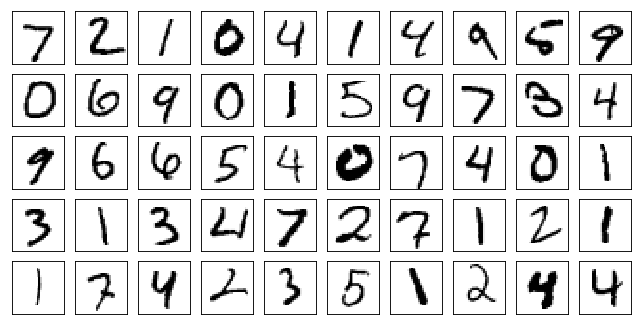

Reconstructed:


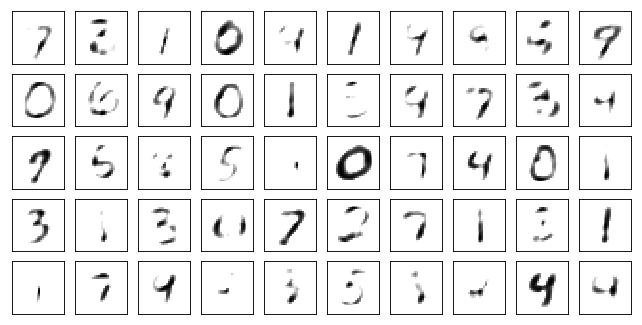

Reconstructed zero-filled:


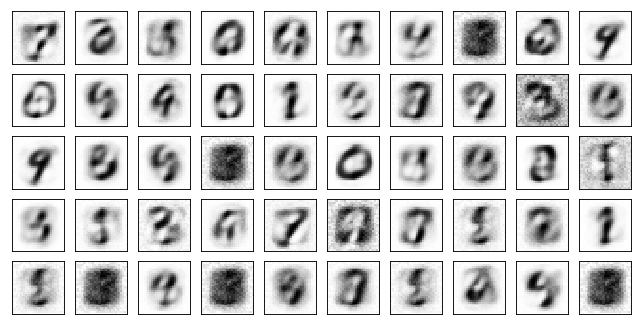

Decode from a sparse vector:


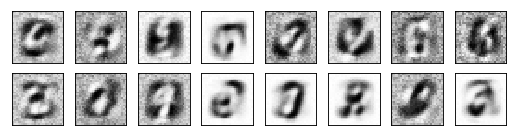

	32 hidden neurons
tensor(1.) tensor(0.)
tensor([ 4,  6,  2,  3,  5,  2,  2,  4,  7,  5,  5,  5,  5,  6,
         4,  4,  2,  6,  6,  4,  3,  4,  2,  5,  3,  8,  3,  4,
         2,  2,  4,  4,  5,  5,  4,  3,  3,  4,  1,  3,  2,  3,
         3,  2,  4,  3,  4,  2,  5,  5], device='cuda:0')
Reference:


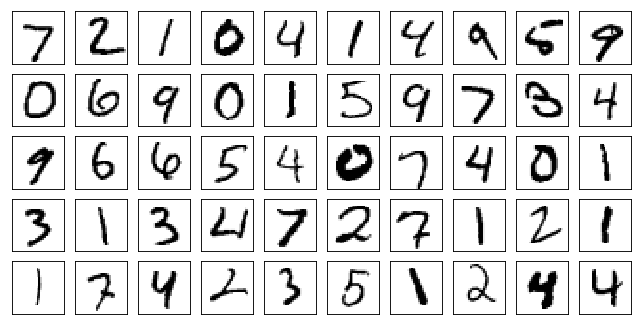

Reconstructed:


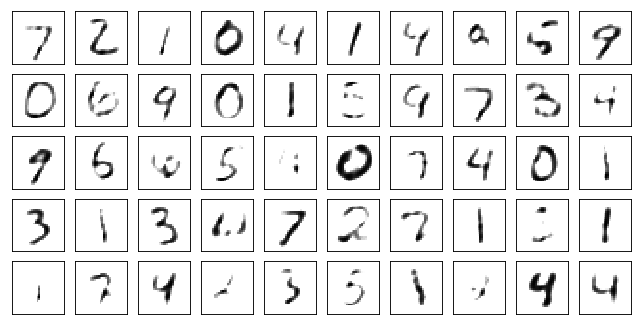

Reconstructed zero-filled:


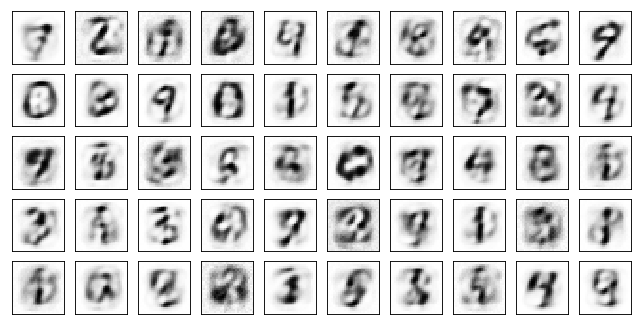

Decode from a sparse vector:


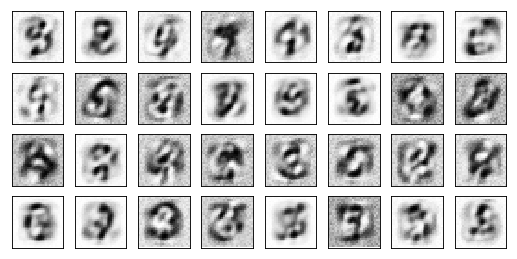

	64 hidden neurons
tensor(1.) tensor(0.)
tensor([ 3,  7,  3,  3,  4,  3,  3,  6,  7,  6,  4,  9,  4,  6,
         3,  6,  4,  4,  6,  2,  3,  4,  5,  2,  4,  7,  2,  0,
         3,  4,  4,  3,  4,  7,  4,  6,  4,  4,  4,  3,  2,  2,
         3,  3,  3,  2,  6,  4,  5,  2], device='cuda:0')
Reference:


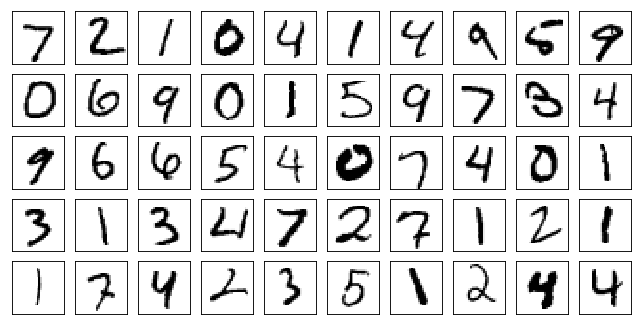

Reconstructed:


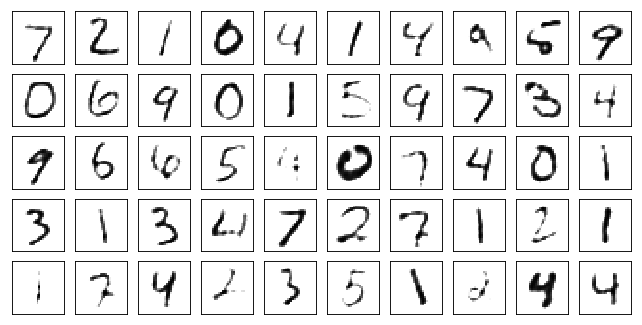

Reconstructed zero-filled:


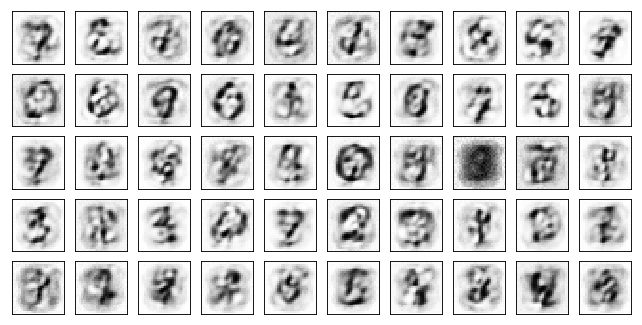

Decode from a sparse vector:


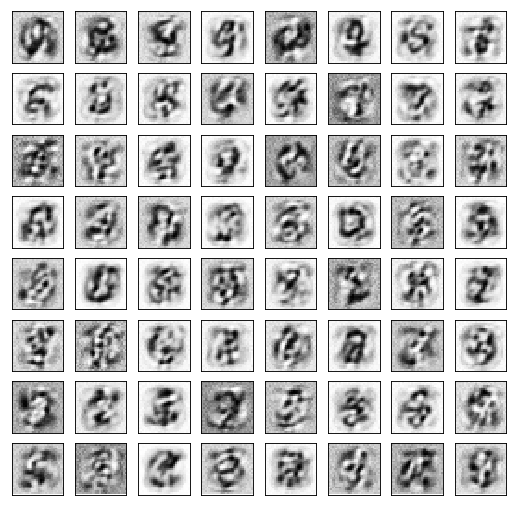

In [114]:
plot_results('16')
plot_results('32')
plot_results('64')

## Construct 2-layer network

In [115]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, latent_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 28*28)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [116]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._l1_reg = None
        self._loss = None
        self.hidden = None  # hidden vector
        self.optim = optim.Adam(self.parameters(), lr=lr)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.hidden = h  # save the hidden vector
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def l1_regularizer(self, size_average=True):
        """
        L1 regularizer
        """
        batch_l1_reg = torch.abs(self.hidden).sum(0)
        if size_average:
            self._l1_reg = batch_l1_reg.mean()
        else:
            self._l1_reg = batch_l1_reg.sum()
        return self._l1_reg
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs) 
        return self._loss

In [117]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
# alpha = [3e-4, 3e-3, 8e-3]     # regularization coefficient
alpha = [1e-3, 3e-3, 7e-3]     # regularization coefficient

train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

[model.to(device) for model in models.values()];

In [118]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.938132 32: 0.926910 64: 0.931179
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.282232 32: 0.280466 64: 0.283567
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.242314 32: 0.253743 64: 0.266090
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.224477 32: 0.238685 64: 0.267806
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.196567 32: 0.216580 64: 0.260486
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.173431 32: 0.191200 64: 0.257723
Test set:
16: loss: 0.1758	l1 reg: 0.1147
32: loss: 0.1920	l1 reg: 0.1543
64: loss: 0.2600	l1 reg: 0.0948

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.150213 32: 0.167981 64: 0.228037
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.152348 32: 0.164066 64: 0.232213
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.154965 32: 0.166260 64: 0.237632
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.142669 32: 0.153971 64: 0.232680
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.132312 32: 0.143758 64: 0.236348
Train Epoch

Train Epoch: 15 [10000/50000 (20%)]	Losses 16: 0.071250 32: 0.050147 64: 0.092179
Train Epoch: 15 [20000/50000 (40%)]	Losses 16: 0.059951 32: 0.041736 64: 0.077025
Train Epoch: 15 [30000/50000 (60%)]	Losses 16: 0.074462 32: 0.054150 64: 0.091907
Train Epoch: 15 [40000/50000 (80%)]	Losses 16: 0.081114 32: 0.055812 64: 0.099616
Train Epoch: 15 [50000/50000 (100%)]	Losses 16: 0.080522 32: 0.054407 64: 0.096523
Test set:
16: loss: 0.0763	l1 reg: 0.0426
32: loss: 0.0529	l1 reg: 0.0659
64: loss: 0.0950	l1 reg: 0.0493

Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.073863 32: 0.053876 64: 0.089646
Train Epoch: 16 [10000/50000 (20%)]	Losses 16: 0.074166 32: 0.052509 64: 0.095525
Train Epoch: 16 [20000/50000 (40%)]	Losses 16: 0.079285 32: 0.053610 64: 0.097901
Train Epoch: 16 [30000/50000 (60%)]	Losses 16: 0.076735 32: 0.052241 64: 0.093859
Train Epoch: 16 [40000/50000 (80%)]	Losses 16: 0.080889 32: 0.054021 64: 0.100057
Train Epoch: 16 [50000/50000 (100%)]	Losses 16: 0.073363 32: 0.050232 64: 0.0

	16 hidden neurons
tensor(1.) tensor(0.)
tensor([ 0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  1,
         0,  0,  0,  1,  0,  0,  0,  2,  1,  0,  0,  1,  0,  0,
         1,  0,  1,  0,  0,  1,  1,  1,  0,  0,  0,  0,  0,  0,
         0,  0,  1,  0,  1,  0,  0,  0], device='cuda:0')
Reference:


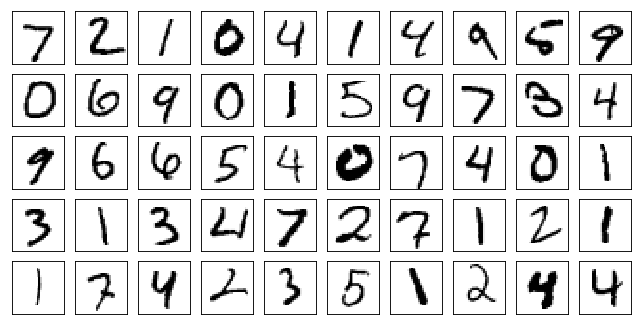

Reconstructed:


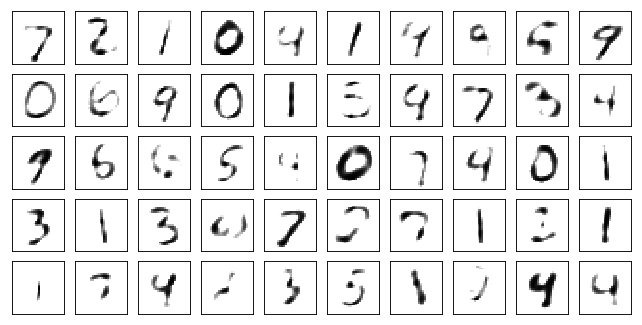

Reconstructed zero-filled:


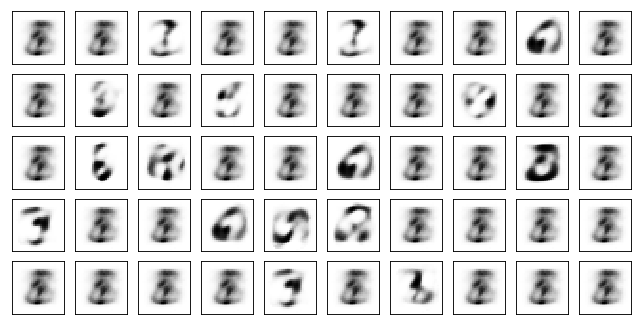

Decode from a sparse vector:


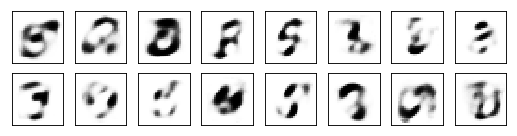

	32 hidden neurons
tensor(1.) tensor(0.)
tensor([ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Reference:


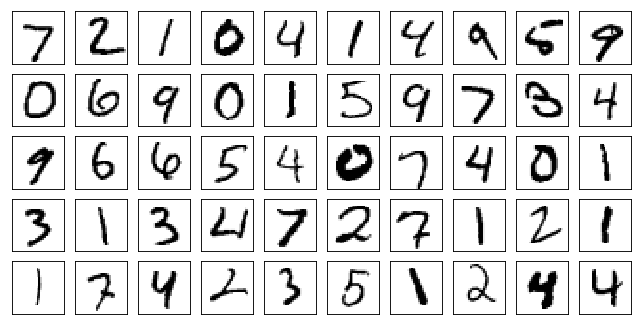

Reconstructed:


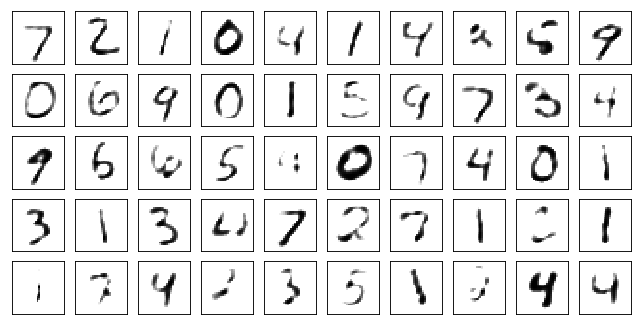

Reconstructed zero-filled:


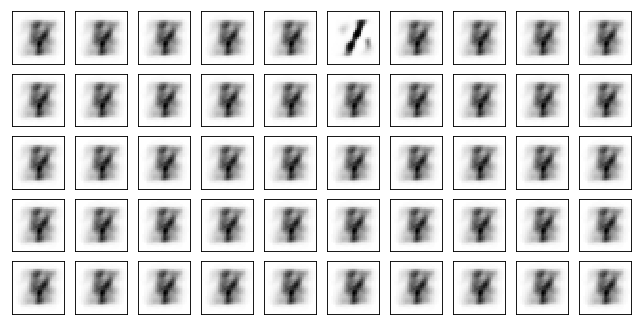

Decode from a sparse vector:


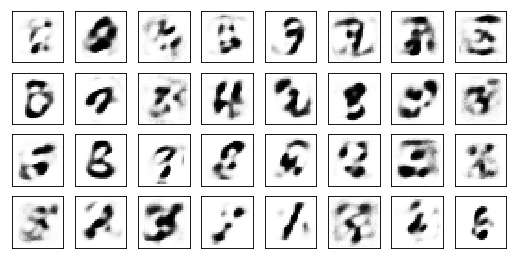

	64 hidden neurons
tensor(1.) tensor(0.)
tensor([ 0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Reference:


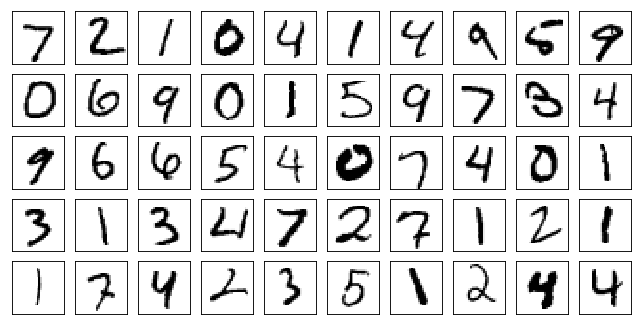

Reconstructed:


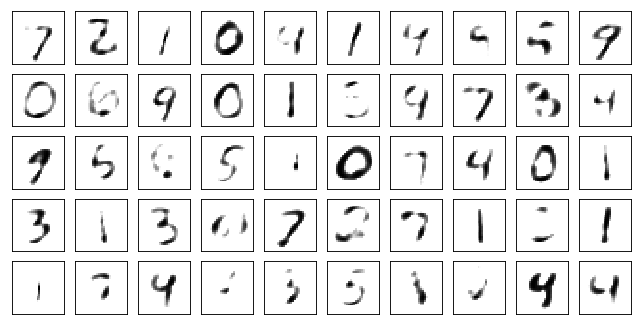

Reconstructed zero-filled:


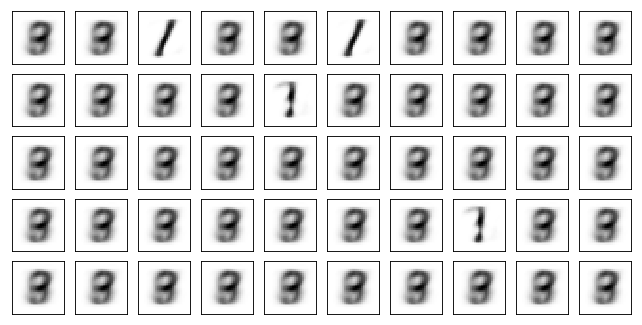

Decode from a sparse vector:


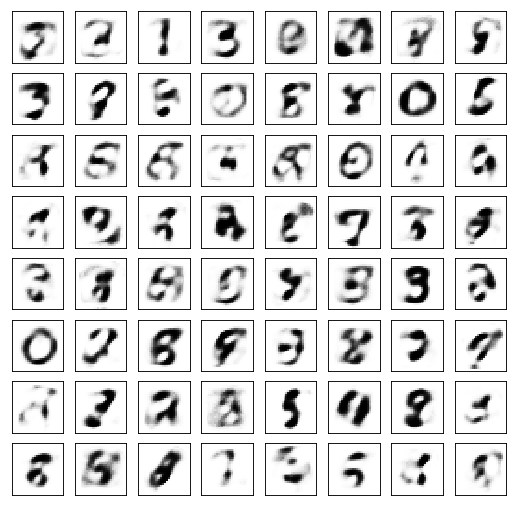

In [119]:
plot_results('16')
plot_results('32')
plot_results('64')